# Identifying trends in modern Greenland temperatures using ice cores
_A final project for Stable Isotope Geochemistry_

By: George Lu and Sam Chester

## 1. Introduction
Comparing isotope records to other measures of climate variability may provide insight into the processes controlling oxygen isotope fractionation and help better understand the regional climate patterns. On geologic time scales, Greenland climate is thought to be most strongly controlled by insolation forcing, however on annual, decadal and centennial scales a number of ocean, atmosphere and cryosphere related effects and feedbacks all generate temperature variability.  Broadly, Greenland climate is characterized by a gradient from warm and wet conditions in the south to drier and colder environments in the North, although local climates are further complicated by the north atlantic oscillation, cyclone patterns, arctic sea ice conditions, ocean currents and, in the last few decades, arctic amplification. These complications make assessing temporal variability challenging. Still, it may be insightful to assess how coastal temperature may correlate to isotope fractionation. For example, warmer coastal climates may link to warmer sea surface temperatures, thus affecting the source water conditions and consequently the isotopic composition of the precipitation that makes it to the ice sheet surface. Alternatively, temperature may be a proxy for sea ice extent, again influencing source water regions and the oxygen isotope ratio. Investigating annual precipitation records in coastal sights may also provide valuable context for ice core data, however this is outside the scope of this project. 

We are approaching our investigation from a novice's perspective. First, we look at trends between cores to identify any spatiotemporal relationships. Next, we compare the ice-core data with historical temperature observations from coastal Greenland to further establish if there's any identifiable spatiotemporal trends. 

The project is formatted as a Jupyter Notebook. It includes blocks of code which conduct our analysis and generates figures. Before we continue to the next section, we need to import some relevant Python libraries for our analysis. The comment at the top of each code cell describes the action done by the cell, and any outputs from the code will appear below the cell. 

In [41]:
# Import libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import glob
import os
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
import xarray as xr
import cartopy as crt
import cartopy.crs as ccrs
from adjustText import adjust_text
from PIL import Image
from IPython.display import display


## 2. Data
### 2.1 Ice Cores
The following section and its subsections describe all the ice core data we use. Each core-specific subsection describes when the core was acquired, the location of each drilling site, and what initial findings were made with the core. For the purpose of saving space, all the cores will be plotted together at the end of this section. The Renland and NEEM core d18O values were accessed online and downloaded from the [Centre for Ice and Climate](https://www.iceandclimate.nbi.ku.dk/data/) at the Niels Bohr Institute, while the remaining core data from GISP was directly accessed online from the [NOAA National Centers for Environmental Information](https://www.ncei.noaa.gov/pub/data/paleo/icecore/greenland/gisp/). The d18O values of all these cores are in reference to SMOW.

#### 2.1.1 Camp Century


In [52]:
# Load Camp century core data
cc = pd.read_csv("https://www.ncei.noaa.gov/pub/data/paleo/icecore/greenland/gisp/campcentury/cc-1ynew.txt", sep="	",skiprows=75, names=["year", "cc"],dtype='float')
cc = cc.set_index('year')
cc_latlonelev = (77.167,-61.133,1885)

#### 2.1.2 Crete
TEXT

In [53]:
crete = pd.read_csv("https://www.ncei.noaa.gov/pub/data/paleo/icecore/greenland/gisp/crete/crt74-1y.txt", sep="	",skiprows=17, names=["year", "crete"],dtype='float')
crete = crete.set_index('year')
crete_latlonelev = (71.117,-37.317,3174)

#### 2.1.3 Dye 2
TEXT

In [54]:
# Load Dye 2 data and plot
# online link: https://www.ncei.noaa.gov/pub/data/paleo/icecore/greenland/gisp/dye2/del1dye2.txt
# not being parsed properly, so reading from local csv

dye2 = pd.read_csv("data/dye2/dye2.csv",names=["year", "dye2"],dtype='float')[:-1]
dye2 = dye2.set_index('year')
dye2_latlonelev = (66.38,-46.18,2332)

#### 2.1.4 Dye 3
TEXT

In [55]:
# Load Dye 3 data and plot
# only loading later portions

dye3 = pd.read_csv("https://www.ncei.noaa.gov/pub/data/paleo/icecore/greenland/gisp/dye3/dye3-1yr.txt", sep="	",skiprows=17, names=["year", "dye3"],dtype='float')[:700]
dye3 = dye3.set_index('year')
dye3_latlonelev = (65.18,-42.82,2477)

#### 2.1.5 Milcent
TEXT

In [56]:
milcent = pd.read_csv("https://www.ncei.noaa.gov/pub/data/paleo/icecore/greenland/gisp/milcent/mc73-1y.txt", sep="	",skiprows=20, names=["year", "milcent"],dtype='float')
milcent = milcent.set_index('year')
milcent_latlonelev = (70.3,-44.58,2410)

#### 2.1.6 Summit
TEXT

In [57]:
# Load Summit data and plot
summit = pd.read_csv("https://www.ncei.noaa.gov/pub/data/paleo/icecore/greenland/gisp/summit/sum74-1y.txt", sep="	",skiprows=79, names=["year", "summit"],dtype='float')
summit = summit.set_index('year')
summit_latlonelev = (71.28,-37.93,3200)

#### 2.1.7 NEEM
TEXT

In [58]:
# Load NEEM data and plot
neem = pd.read_csv("data/neem/NEEM.csv",dtype='float').rename(columns={'d18o':'neem'})
neem = neem.set_index('year')
neem_latlonelev = (77.45,-51.06,2450)

#### 2.1.8 Renland
TEXT

In [59]:
# Load Renland data and plot
renland = pd.read_csv("data/renland/renland.csv",dtype='float')
renland = renland.set_index('year')
renland_latlonelev = (71.305,-26.723,2331)

Now that we have taken a peek at all of our selected core sites, we compile them together. We use the Pandas python package for this purpose, and create a table that has the mean d18O value (along with the standard deviation), longitude, latitude, and elevation for each ice core.

In [11]:
# Compiling the cores and making the table
all_cores = pd.concat([cc,crete,dye2,dye3,milcent,summit,neem,renland],axis=1).sort_index()

site_data = [cc_latlonelev,crete_latlonelev,dye2_latlonelev,dye3_latlonelev,
             milcent_latlonelev, summit_latlonelev,neem_latlonelev,renland_latlonelev]
core_info = all_cores.mean().to_frame('mean_d18o')
core_info['mean_sigma'] = all_cores.std()
core_info['lon'] = [site[1] for site in site_data]
core_info['lat'] = [site[0] for site in site_data]
core_info['h'] = [site[2] for site in site_data]

Displaying the table below, we note that the standard devation of d18O data across all the cores fluctuate around 1, even though the mean values are quite different across the cores. This near-uniform standard deviation suggests that regardless of location, the variability in d18O as a result of climate forcing are relatively consistent between these sites.

In [12]:
core_info

,mean_d18o,mean_sigma,lon,lat,h
cc,-29.333471,1.167465,-61.133,77.167,1885
crete,-34.212375,1.027779,-37.317,71.117,3174
dye2,-26.265880,1.087926,-46.180,66.380,2332
dye3,-27.984386,0.960265,-42.820,65.180,2477
milcent,-29.688687,1.048183,-44.580,70.300,2410
summit,-35.184286,1.139567,-37.930,71.280,3200
neem,-33.627639,1.184301,-51.060,77.450,2450
renland,-27.338411,0.989717,-26.723,71.305,2331


To better visualize the spatial distribution of the core sites, we plot them on a map using our recorded latitudes and longitudes. We also abbreviate the names to keep the plot clean. Abbreviations are as follows: CC (Camp Century), Cr (Crete), D2 (Dye 2), D3 (Dye 3), Mi (Milcent), Su (Summit), NEEM (NEEM), and Re (Renland). Referring to a [velocity map](https://www.cambridge.org/core/journals/journal-of-glaciology/article/complete-map-of-greenland-ice-velocity-derived-from-satellite-data-collected-over-20-years/D22454AF22391DF03754BE6DF4C70366) from Joughin et al. (2017), we can see that these cores roughly lie within zones of slow surface velocity, indicating that the ice is less likely to be advected, which means that the layers within the ice should be well preserved. 

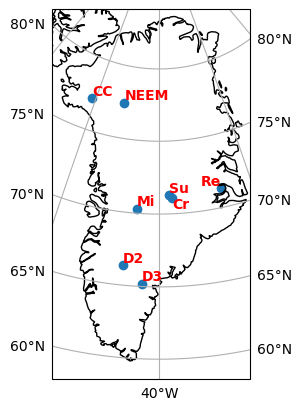

In [13]:
# Plotting core locations
projection = ccrs.PlateCarree()
fig_proj = ccrs.Orthographic(central_latitude=70, central_longitude=-40)
fig, ax = plt.subplots(subplot_kw={'projection': fig_proj})

p1 = ax.scatter(core_info.lon,core_info.lat,transform=projection)
site_names = ['CC', 'Cr','D2', 'D3','Mi', 'Su', 'NEEM', 'Re']

texts = [ax.text(lon, lat, name, transform=projection,
            fontsize=10, color='red', fontweight='bold') for name,lon,lat in zip(site_names,core_info.lon,core_info.lat)]
adjust_text(texts,ax=ax)
    
ax.set_extent([-54, -28.2, 58, 84], crs=projection)  
ax.gridlines(draw_labels=True).top_labels = False
ax.coastlines()

Below is the velocity plot from Joughin et al. (2017).

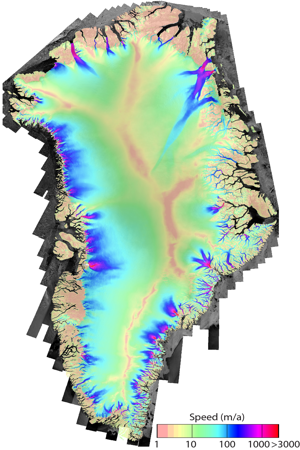

In [51]:
img = Image.open('urn_cambridge.org_id_binary_20180307065926650-0357_S0022143017000739_S0022143017000739_fig3g.jpeg').resize((300,450))
display(img)


Some future analysis could involve verifying fully the velocities at the core sites to validate if the sites fit the requirements of having the ice be static. However, this project was done locally on a laptop, which could not effectively process the volume of data associated with these ice velocity maps. Next, we plot all the d18O values from the cores together, shown below.

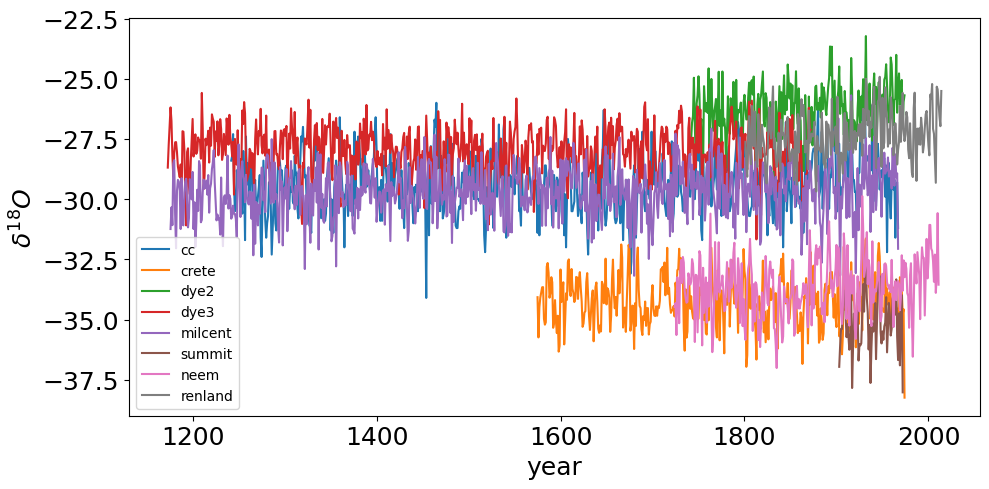

In [60]:
# Plot all cores
fig, ax = plt.subplots(figsize=(10,5),layout='tight')

all_cores.plot(ax=ax)
plt.ylabel('$\delta^{18}O$',fontsize=18)
plt.xlabel('year',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

From the above plot, we see that the interannual variations in d18o values for the cores do not exhibit an obvious pattern between cores. Temporally, it looks like the d18o values for the NEEM and Renland cores start to increase at around 1980 or so, which could be indicative of an anthropegenic signal. It would be interesting to revisit the other core sites and see if they show the same uptick. 


### 2.2 Historic Temperatures
To investigate the links between the oxygen isotope record and local climate, we compiled and analyzed published historical temperature data from coastal cities and towns around Greenland. The data is made available by the Danish Meteorological Institute (Report 18-04). We selected eleven number sites which had continuous and substantial temperature records: Pituffik, Upernavik, Ilulissat, Nuuk, Ivittuut, Narsarsuaq, Qaqortoq, Danmarkshavn, Scoresbysund, Ittoqqortoormiit, Tasiilaq. The meteorological stations themselves are generally associated with airports and run by municipal governments. Many sites are concentrated in Southern Greenland with a few spaced along the east and west coasts. No time series exists for the Northernmost part of Greenland adjacent to the Arctic Sea. 

For each location, we calculated annual averages directly from the monthly temperature dataset. Data coverage varies between locations but many span the last few centuries. Additionally, we calculate mean temperature for the time series at each location. A clear latitude-temperature relationship is present, driven primarily by the differences in winter temperature, as the midnight sun keeps northern temperatures relatively similar to southern temperatures during the summer months (DMI, Report 18,04). These calculations were done in Excel, and saved as a .csv file to be uploaded into this Jupyter notebook. Additionally, all the station location information was saved as a seperate .csv to be uploaded. The following cell loads the station information.


In [14]:
station_info = pd.read_csv('data/temp_data/station_locations.csv')
station_info = station_info.set_index('stat_num')
station_info.index = station_info.index.map(str)

The next section loads all the temperature data and plots it together. The temperature record in northern Greenland is relatively more stable through the last few centuries than along the southern coastlines. A few of the time series (X, X, X) from the south show a warm period during the early to mid-twentieth century. This trend is less pronounced at Northern locations. Also present in the historical record is late twentieth and early twenty-first century anthropogenic warming. 

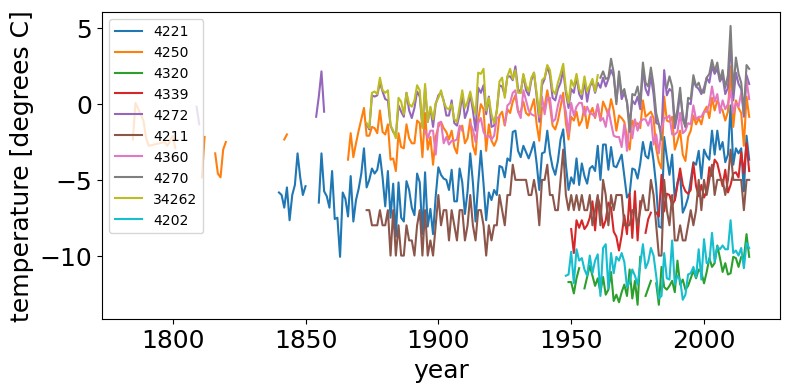

In [16]:
# load temperature data
def load_csv(folder):
    filenames = glob.glob(f"{folder}/*_cln.csv")

    li = []

    for filename in filenames[:]:
        df = pd.read_csv(filename, dtype='float').T
        df = df.rename_axis('year')
        name = filename.split('_')[2]
        df = df.rename(columns={0:f'{name}'})
        #print(f'{name}:{len(df.index)}')

        df.index = df.index.map(int)
        if len(df.index) >10:# and df.index[0]<1950:
            li.append(df)
        
    return pd.concat(li,axis=1).sort_index()

all_temp = load_csv('data/temp_data')
fig, ax = plt.subplots(figsize=(8,4),layout='tight')
all_temp.plot(ax=ax)
plt.ylabel('temperature [degrees C]',fontsize=18)
plt.xlabel('year',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

Displaying the station information below, we see that there appears to be a good spatial distribution. However, we notice that all the elevations are much lower than the core elevations, which validates our knowledge that these stations are all near the coast. Additionally there is quite a bit of variation in mean temperature, and we see that it's quite related to latitude.

In [17]:
temp_info = all_temp.mean().to_frame('mean_temp')
temp_info=temp_info.join(station_info)
temp_info

,mean_temp,location,lon,lat,elevation
4221,-4.790474,Mittarfik Ilulissat,-51.0358,69.1425,29
4250,-1.493661,Nuuk,-51.4500,64.1000,54
4320,-11.457085,Danmarkshavn,-18.4000,76.4600,11
4339,-6.359853,Ittoqqortoormiit,-21.5800,70.2500,41
4272,0.506069,Qaqortoq,-46.0300,60.4300,32
4211,-6.958621,Mittarfik Upernavik,-56.0750,72.4725,126
4360,-0.969888,Tasiilaq,-37.3800,65.3600,50
4270,1.157744,Mittarfik Narsarsuaq,-45.2532,61.0939,34
34262,0.627839,Ivittuut,-48.1100,61.1200,30
4202,-10.557131,Pituffik,-68.4500,76.3200,77


Finally, we map the temperature stations to visualize their spatial distribution. They are indeed all along the coastline.

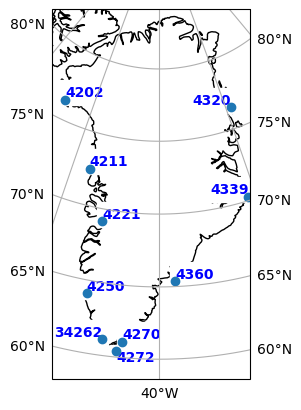

In [18]:
projection = ccrs.PlateCarree()
fig_proj = ccrs.Orthographic(central_latitude=70, central_longitude=-40)
fig, ax = plt.subplots(subplot_kw={'projection': fig_proj})

p1 = ax.scatter(temp_info.lon,temp_info.lat,transform=projection,zorder=2)
site_names = temp_info.index
ax.coastlines(zorder=0)
texts = [ax.text(lon, lat, name, transform=projection,
            fontsize=10, color='blue', fontweight='bold',backgroundcolor='white',zorder=1) for name,lon,lat in zip(site_names,temp_info.lon,temp_info.lat)]
adjust_text(texts,ax=ax)
    
ax.set_extent([-54, -28.2, 58, 84], crs=projection)  
ax.gridlines(draw_labels=True).top_labels = False


# 3. Identifying spatiotemporal trends in ice-core data

The goal of this section is to identify trends within the cores themselves, without comparing them to other datasets. First, we plot all the core data together. We will first look for trends in time across all the cores, before looking at any trends in space.

To quantify if there's a pattern or not between the cores, we calculate the Pearson correlation coefficient (r) between each core, done in the next cell.

In [20]:
# Calculate correlations
corr = all_cores.corr()
corr.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1)

,cc,crete,dye2,dye3,milcent,summit,neem,renland
cc,1.000000,0.116246,0.035251,-0.096291,0.025009,0.159870,0.232908,0.027767
crete,0.116246,1.000000,0.200295,0.343738,0.444135,0.500496,0.163201,0.405798
dye2,0.035251,0.200295,1.000000,0.253898,0.286428,0.292971,0.158935,0.126845
dye3,-0.096291,0.343738,0.253898,1.000000,0.092024,nan,0.223801,0.242987
milcent,0.025009,0.444135,0.286428,0.092024,1.000000,0.576790,0.218162,0.206872
summit,0.159870,0.500496,0.292971,nan,0.576790,1.000000,0.314320,0.228719
neem,0.232908,0.163201,0.158935,0.223801,0.218162,0.314320,1.000000,0.208616
renland,0.027767,0.405798,0.126845,0.242987,0.206872,0.228719,0.208616,1.000000


From above, we see that there aren't strong correlations between any of the cores. Consequently, given the different locations and elevations of each core, we cannot confidently say that there are any temporal trends on an annual basis across the ice sheet. Rather, these variations are more likely to be due to regional climate differences. We also note that the "nan" values are due to the cores not having any overlapping years.

The core that seems to have the most strong correlations with others is NEEM, which is most strongly positively correlated with the longer Camp Century core (r=0.48). It is the closest to the Camp Century site, so perhaps there are some more regional trends in time.

Next, we try smoothing the data by taking a decadal rolling average, to see if it can reveal any trends in time. We also zoom into the 200 year window between 1700 and 2000 to focus on time periods where we have the most data.

(1700.0, 2000.0)

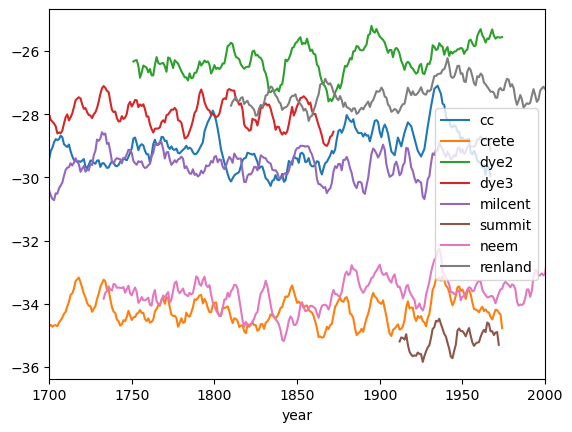

In [21]:
# decadal average
dec_avg = all_cores.rolling(10).mean()
dec_avg.plot()
plt.xlim([1700,2000])

We see that there are now some very obvious multidecadal oscillations. Also noticeable is a peak in all the cores except for Renland and Dye 2 in the mid-1930s. However, the trends in these timeseries are still different from one another. We calculate the correlation coefficient for this smoothed data below. 

In [22]:
# correlation of smoothed data
corr = dec_avg.corr()
corr.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1)

,cc,crete,dye2,dye3,milcent,summit,neem,renland
cc,1.000000,0.174923,0.222866,-0.092601,0.064465,0.236078,0.591334,0.293037
crete,0.174923,1.000000,0.273007,0.428677,0.567900,0.526269,0.243237,0.520265
dye2,0.222866,0.273007,1.000000,0.608315,0.521462,0.632841,0.348193,0.059151
dye3,-0.092601,0.428677,0.608315,1.000000,0.200791,nan,0.398277,-0.399399
milcent,0.064465,0.567900,0.521462,0.200791,1.000000,0.687215,0.245864,0.349533
summit,0.236078,0.526269,0.632841,nan,0.687215,1.000000,0.555285,0.314999
neem,0.591334,0.243237,0.348193,0.398277,0.245864,0.555285,1.000000,0.369450
renland,0.293037,0.520265,0.059151,-0.399399,0.349533,0.314999,0.369450,1.000000


Now, the correlation values between core sites are a lot stronger. With the exception of Dye 3 and Renland with one another, the cores all seem to be generally positively correlated, which suggests that there is likely a decadal temporal trend across all of these sites. We also note that Dye 3 and Renland are our two most coastal cores, so perhaps their negative correlation is due to different coastal climates. Additionally, Dye 3 is the southernmost core site, so its stark difference with the other cores that are not Dye 2 (which is also quite south) could be a reflection of the aforementioned greater variability in southern temperatures that was noted in our initial processing of temperature data.

The strongest correlation values are between Dye 2 and Dye 3, Dye 2 and Summit, and Milcent and Summit. Dye 2 and Dye 3 being strongly correlated is likely due to their proximity with one another. Milcent and Summit having a strong correlation could also be a result of proximity, but also we note that our Summit d18O time series is very short compared to the others, so only a short window of strongly correlated trends exists. In this window, we see the majority of cores undergo the same upward swing in d18O values at around 1925. Referring to a plot of the [Atlantic Multidecadal Oscillation](https://climatedataguide.ucar.edu/climate-data/atlantic-multi-decadal-oscillation-amo) (AMO, plot shown below), we see this same swing in that time period. Therefore, it is quite likely that our cores have captured this multi-decadal climate pattern. Only Dye 2 and Renland lack this upward swing, so they may be experiencing other climate effects at those sites, or the AMO is more pronounced inland, and towards the North.

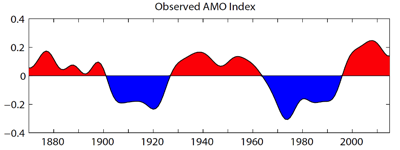

In [63]:
img = Image.open('AMOindex-Zhang.png').resize((400,150))
display(img)


We will see if our core data agrees with observed trends in coastal temperatures in Section 4. Before we do that, we first look for spatial trends in data. 

Our first way of doing this is once again looking at the Pearson correlation coefficient. This time, we will be calculating it using the data across the sites, which includes the mean d18o value, standard deviation of the d18o values, longitude, latitude, and elevation of all the core sites.

In [23]:
# correlation of values across sites
corr = core_info.corr()
corr.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1)

,mean_d18o,mean_sigma,lon,lat,h
mean_d18o,1.000000,-0.446573,-0.014154,-0.463000,-0.727239
mean_sigma,-0.446573,1.000000,-0.659084,0.739873,-0.123329
lon,-0.014154,-0.659084,1.000000,-0.449984,0.535366
lat,-0.463000,0.739873,-0.449984,1.000000,-0.218912
h,-0.727239,-0.123329,0.535366,-0.218912,1.000000


Since there are not too many core sites, and thus not too many data points, our resulting correlation matrix has some pretty large values. Aspects that we do not expect to be correlated, such as the longitude and elevation, show pretty strong correlations. A particularly interesting result is that two correlations that we expected to be strongly negative (d18o vs latitude, d18o vs elevation) are only about as strong as the other correlations that should have less meaning (like longitude vs latitude). Thus the next step in analysis is to understand why that is the case.

First, we try running a linear regression for mean d18o as a function of latitude or elevation seperately. The results are plotted below.

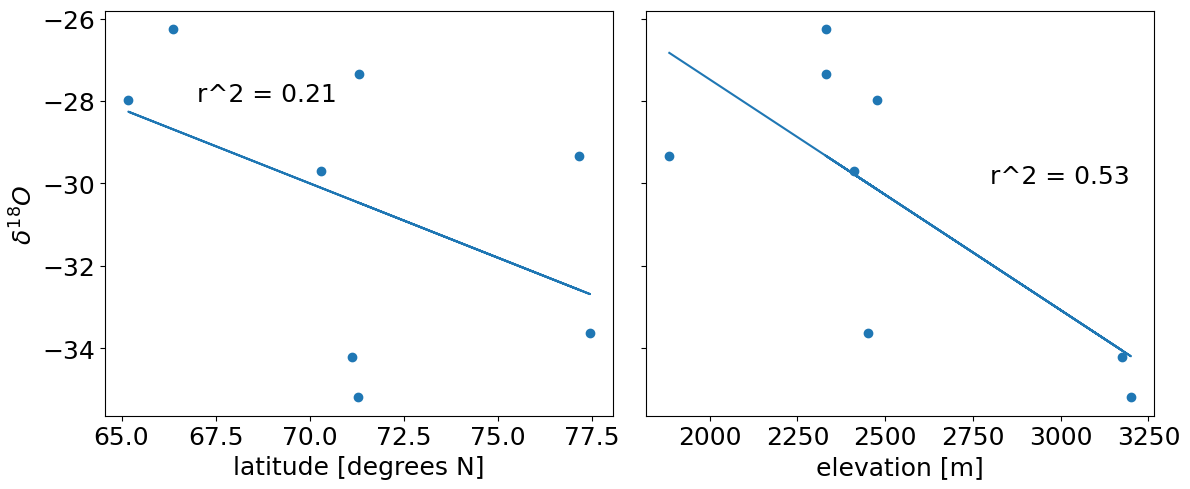

In [24]:
fig, axs = plt.subplots(ncols=2, figsize = (12,5),sharey=True,layout='tight')

x=core_info.lat.values.reshape(len(core_info.lat.values),1)
y= core_info.mean_d18o.values.reshape(len(core_info.lat.values),1)
regr = linear_model.LinearRegression()
regr.fit(x, y)
axs[0].scatter(x,y)
axs[0].plot(x, regr.predict(x))
axs[0].text(67, -28, f"r^2 = {r2_score(y,regr.predict(x)):.2}",fontsize=18)
axs[0].set_ylabel('$\delta^{18}O$',fontsize=18)
axs[0].set_xlabel('latitude [degrees N]',fontsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=18)                  

x = core_info.h.values.reshape(len(core_info.h.values),1)
regr = linear_model.LinearRegression()
regr.fit(x, y)
axs[1].scatter(x,y)
axs[1].plot(x, regr.predict(x))
axs[1].text(2800, -30, f"r^2 = {r2_score(y,regr.predict(x)):.2}",fontsize=18)
axs[1].set_xlabel('elevation [m]',fontsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=18)                  


We see that the r-squared values are quite low, and although there is a slight negative correlation for both, this is clearly not a good fit. However, we then recognize that some sites at high elevations (e.g. Summit at ~3200 m) aren't at high latitudes compared to others. Therefore, we try applying a linear regression with d18O being a function of both elevation and latitude.

The below plot shows d18O values as a function of both elevation and latitude (circles), and also has projections of d18O as solely functions of elevation (+ markers on the d18O-h plane) or latitude (x markers on the d18O-lat plane). It also plots the new line of best fit that is a function of both latitude and elevation. 

Text(0.5, 0.92, 'r^2 = 0.94')

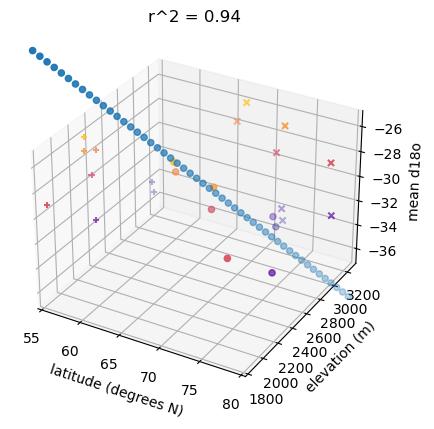

In [25]:
import matplotlib.colors as cl
import matplotlib.cm as cmx

fig = plt.figure()
cs = core_info.mean_d18o.values
cm = plt.get_cmap('plasma')
cNorm = cl.Normalize(vmin=min(cs), vmax=max(cs)*0.95)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
ax = fig.add_subplot(projection='3d')
ax.scatter(core_info.lat, core_info.mean_d18o, zs=3300, zdir='y', c=scalarMap.to_rgba(cs),linestyle='None',marker='x')
ax.scatter(core_info.h, core_info.mean_d18o, zs=55, zdir='x', c=scalarMap.to_rgba(cs),linestyle='None',marker='+')
#ax.scatter(core_info.lat, core_info.h, zs=-40, zdir='z', c=scalarMap.to_rgba(cs),linestyle='None',marker='*')
ax.scatter(core_info.lat,core_info.h,core_info.mean_d18o,c=scalarMap.to_rgba(cs),linestyle='None',marker='o')

x_new = np.concatenate((core_info.lat.values,core_info.h.values)).reshape(len(core_info.lat.values),2,order='F')
regr.fit(x_new, y)
r2 = r2_score(y,regr.predict(x_new))

x_fit = np.linspace(55,80)
y_fit = np.linspace(1800,3300)
x_pred = np.concatenate((x_fit,y_fit)).reshape(50,2,order='F')
z_pred = regr.predict(x_pred)
ax.scatter(x_fit,y_fit,z_pred.reshape(len(z_pred),))

ax.set_xlim([55, 80])
ax.set_ylim([1800, 3300])
ax.set_zlim([-37,-25])

# Set the axis labels
ax.set_xlabel('latitude (degrees N)')
ax.set_ylabel('elevation (m)')
ax.set_zlabel('mean d18o')
ax.set_title(f"r^2 = {r2:.2}")


This plot helps (slightly) to illustrate the dependence that d18O has on both elevation and latitude. It also shows the fit in 3D space, which is a lot better than the individual fits for the single variables with an r-squared value of 0.92. Consequently, we do see d18O dependencies on latitude and elevation as expected. Next, we see if we can extend this analysis towards observed coastal temperatures. 

## 4. Comparing ice-core data with observations.

First, to investigate broader trends across the entirety of Greenland, we take the normalized temperature at each station, and then take the mean across all the stations to get an approximate mean for the continent. We do the same normalization and averaging procedure for the d18O data. Then, we can compare the two directly to see if they capture the same continent-wide trends.

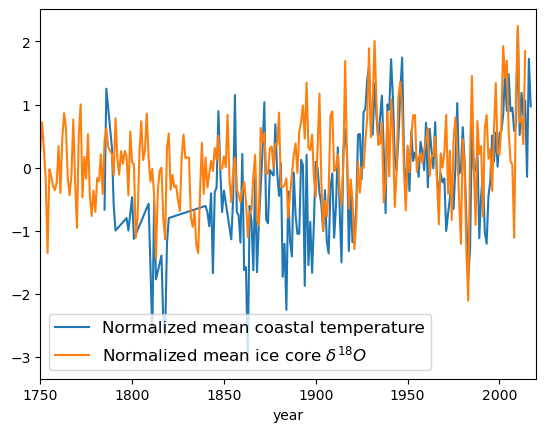

In [26]:
all_temp_normal=(all_temp-all_temp.mean())/all_temp.std()

all_temp_normal.mean(axis=1).plot(label = 'Normalized mean coastal temperature')

all_core_normal=(all_cores-all_cores.mean())/all_cores.std()

all_core_normal.mean(axis=1).plot(label='Normalized mean ice core $\delta^{18}O$')
plt.xlim([1750,2020])
plt.legend(fontsize=12)

From the above plot, it seems like the two time series do track the same broad patterns. However, we recognize that there is less temperature data pre-1900 or so, so there are biases towards the few stations that do have data at that time, which could explain the divergence from the ice core data. Additionally, post-1980 or so, we only have the NEEM and Renland cores, so there are biases arising from there as well. Notably, in that period of time, 1 out of the two cores (Renland) is very close to the coast, so it may be reflecting the coastal temperatures better. As with the ice cores, we apply decadal smoothing next to identify if there's any decadal trends. The resulting figure is shown below. 

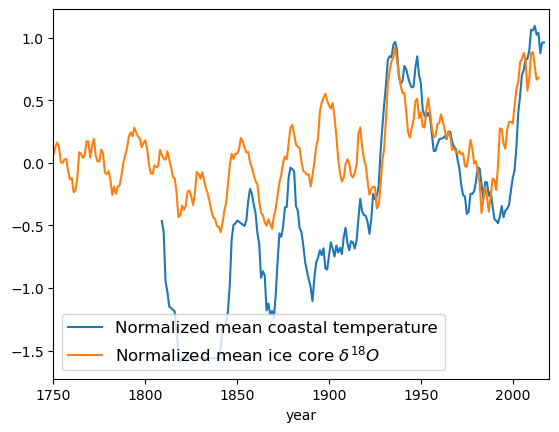

In [64]:
all_temp_normal.mean(axis=1).rolling(10).mean().plot(label = 'Normalized mean coastal temperature')
all_core_normal.mean(axis=1).rolling(10).mean().plot(label='Normalized mean ice core $\delta^{18}O$')
plt.xlim([1750,2020])
plt.legend(fontsize=12)

From the figure above, we see the biases of a lack of data get exaggerated further, with the temperatures consistently underestimating the trends in d18O pre-1930. However, we do still see some of the larger oscillatory patterns, though there is a missing oscillation from the temperatures centered around 1900. In our more data-rich period of 1930-1980 (after which, we do not have much ice core data), we see some strong correlation between the normalized mean temperature and the normalized mean d18O value. Most notably, we see the same upswing at around 1925-1930 that we identified to be the AMO pattern in Section 3. This suggests that d18O broadly tracks broad regional climate patterns, across longer time scales. For completion, we also calculate the correlation between these two time series, both with and without decadal smoothing. This is done with the following two lines of code:

In [28]:
all_temp_normal.mean(axis=1).corr(all_core_normal.mean(axis=1))

0.5742321179987331

In [29]:
all_temp_normal.mean(axis=1).rolling(10).mean().corr(all_core_normal.mean(axis=1).rolling(10).mean())

0.7667078863824056

We see that there are strong positive correlations across these normalized means, once again emphasizing that the broader regional trends persist between these two data sets. Our next step is to investigate how these trends hold up spatially. To first do that, we investigate if the temperature stations exhibit similar relations between one another, like we did with the ice core sites. First we calculate how well correlated each station timeseries is with each other.

In [30]:
corr = all_temp.corr()
corr.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1)

,4221,4250,4320,4339,4272,4211,4360,4270,34262,4202
4221,1.000000,0.920520,0.323991,0.185892,0.843800,0.910363,0.669597,0.878063,0.781817,0.851424
4250,0.920520,1.000000,0.219131,0.048222,0.943819,0.837871,0.655111,0.954053,0.922687,0.763950
4320,0.323991,0.219131,1.000000,0.771971,0.189871,0.426325,0.686955,0.234278,0.004420,0.425589
4339,0.185892,0.048222,0.771971,1.000000,0.088201,0.194638,0.555019,0.137148,0.399027,0.166915
4272,0.843800,0.943819,0.189871,0.088201,1.000000,0.760756,0.654998,0.976587,0.964191,0.673681
4211,0.910363,0.837871,0.426325,0.194638,0.760756,1.000000,0.678767,0.762931,0.698298,0.891709
4360,0.669597,0.655111,0.686955,0.555019,0.654998,0.678767,1.000000,0.594908,0.737622,0.512889
4270,0.878063,0.954053,0.234278,0.137148,0.976587,0.762931,0.594908,1.000000,nan,0.699111
34262,0.781817,0.922687,0.004420,0.399027,0.964191,0.698298,0.737622,nan,1.000000,0.406255
4202,0.851424,0.763950,0.425589,0.166915,0.673681,0.891709,0.512889,0.699111,0.406255,1.000000


We see that in contrast to the ice core data, the temperature stations have much stronger correlations in some instances. The highest ice core correlation coefficient was about 0.69, whereas there are many temperature station pairs that have correlations well above 0.7, with some being higher than 0.9. Referring to these locations on the map, the cores with the strongest correlations are all the ones at the southern tip of Greenland, which further agrees with our understanding that the south has different climate patterns compared to the north. Overall, it appears that the higher correlations are due to proximity for another, with distinct differences between both the north and south of the continent, and some slight differences between the east and the west as well. These trends are a lot stronger within the temperature stations than they are with the ice cores, as examined earlier.

Next, we look at spatial trends in temperature. 

In [31]:
corr = temp_info.corr()
corr.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1)

,mean_temp,lon,lat,elevation
mean_temp,1.000000,-0.118173,-0.989470,-0.233397
lon,-0.118173,1.000000,0.076434,-0.569143
lat,-0.989470,0.076434,1.000000,0.307632
elevation,-0.233397,-0.569143,0.307632,1.000000


We see that since there's not as much variation in elevation between the station sites, the mean temperature is almost entirely dependent on latitude, with an extremely negative correlation. 

Now, we finally try examining all the correlations between the individual cores and temperature stations. This generates a large correlation matrix, and we focus only on the station-core correlation values.

In [32]:
everything = pd.concat([all_cores,all_temp],axis=1).sort_index()
corr=everything.corr()
corr.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1)

,cc,crete,dye2,dye3,milcent,summit,neem,renland,4221,4250,4320,4339,4272,4211,4360,4270,34262,4202
cc,1.000000,0.116246,0.035251,-0.096291,0.025009,0.159870,0.232908,0.027767,0.113306,0.074276,0.263453,-0.042825,0.040457,0.101107,0.246318,0.564794,0.103123,0.130734
crete,0.116246,1.000000,0.200295,0.343738,0.444135,0.500496,0.163201,0.405798,0.334057,0.340995,0.015427,-0.257282,0.373398,0.265601,0.423304,0.224082,0.408510,-0.004801
dye2,0.035251,0.200295,1.000000,0.253898,0.286428,0.292971,0.158935,0.126845,0.303775,0.258917,-0.099626,-0.018218,0.312690,0.138632,0.223242,0.390207,0.313218,0.285709
dye3,-0.096291,0.343738,0.253898,1.000000,0.092024,nan,0.223801,0.242987,0.534373,0.562000,nan,nan,0.461338,nan,nan,nan,nan,nan
milcent,0.025009,0.444135,0.286428,0.092024,1.000000,0.576790,0.218162,0.206872,0.436428,0.495842,0.158543,0.277165,0.512107,0.342939,0.457798,0.725804,0.513511,-0.289151
summit,0.159870,0.500496,0.292971,nan,0.576790,1.000000,0.314320,0.228719,0.397190,0.382864,0.046579,0.092596,0.345772,0.348449,0.378771,0.752610,0.202012,0.138942
neem,0.232908,0.163201,0.158935,0.223801,0.218162,0.314320,1.000000,0.208616,0.392929,0.431612,0.261453,0.232709,0.354611,0.362458,0.374537,0.274738,0.360427,0.318606
renland,0.027767,0.405798,0.126845,0.242987,0.206872,0.228719,0.208616,1.000000,0.293365,0.358428,0.383294,0.217489,0.353162,0.385749,0.479681,0.147708,0.441565,0.247686
4221,0.113306,0.334057,0.303775,0.534373,0.436428,0.397190,0.392929,0.293365,1.000000,0.920520,0.323991,0.185892,0.843800,0.910363,0.669597,0.878063,0.781817,0.851424
4250,0.074276,0.340995,0.258917,0.562000,0.495842,0.382864,0.431612,0.358428,0.920520,1.000000,0.219131,0.048222,0.943819,0.837871,0.655111,0.954053,0.922687,0.763950


We see that overall, the core-temperature correlations are about the same in magnitude as the core-core correlations, and much less than the temperature-temperature correlations. This suggests that although both normalized mean timeseries track the same broad climate patterns, there is a lot more regional variability inland of the ice sheet, and that these variabilities also differ from the generally more consistent trends observed around the coast. The two largest core-temperature correlation coefficients are between Summit and 4270 and Milcent and 4270. 4270 is located in Mittarfik Narsarsuaq, and is one of the southernmost temperature stations. Interestingly, even though Dye 2 is closer, it doesn't have as strong a correlation. Consequently, there could be a teleconnection connecting the southernmost coastal temperature with the ice cores further inland. However, the more likely case is that there's little data overlap between the beginning of the 4270 temperature station temperature series (it starts in roughly 1960) and the end of the ice-core time series, as most of the GISP cores end in the 1970s. Having so few points would result in a stronger correlation compared to the longer, more variable timeseries. Consequently, in our next effort to explore spatial trends, we will only look at temperature stations that start recording pre-1950. We explore the spatial trends further by seeing, for each core, if the nearest temperature station is the strongest correlation. We've already done this visually by looking at the maps and the above correlation matrix, but now we will try to quantify the distance. First, we define a function to convert our longitude and latitude values into a distance.

In [37]:
def haversine_distance(lat1, lon1, lat2, lon2):

    R = 6371  # Earth radius, km

    # Convert latitude and longitude from degrees to radians
    lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
    lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)

    # Calculate differences in latitude and longitude
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Calculate the great-circle distance
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Convert to kilometers
    distance = R * c
    return distance


Next, we find the temperature station with the strongest correlation for each ice core, along with the nearest station.

In [90]:
for core in all_cores:
    best_corr = 0
    closest_dist = 1e6
    for series in all_temp:
        corr = all_temp[series].corr(all_cores[core])
        dist = haversine_distance(temp_info.lat[series], temp_info.lon[series], core_info.lat[core], core_info.lon[core])
        if abs(corr) > best_corr and int(all_temp[series].dropna().index[0]) <1950:
            core_info.at[core,'most_corr_temp']=series
            core_info.at[core,'strongest_corr']=corr
            best_corr = abs(corr)
        if dist < closest_dist and int(all_temp[series].dropna().index[0]) <1950:
            core_info.at[core,'closest_stn']=series
            core_info.at[core,'closest_stn_dst']=dist
            closest_dist = dist

In [91]:
core_info

,mean_d18o,mean_sigma,lon,lat,h,most_corr_temp,strongest_corr,closest_stn,closest_stn_dst
cc,-29.333471,1.167465,-61.133,77.167,1885,4320,0.263453,4202,208.803971
crete,-34.212375,1.027779,-37.317,71.117,3174,4360,0.423304,4221,561.486155
dye2,-26.265880,1.087926,-46.180,66.380,2332,34262,0.313218,4250,352.638209
dye3,-27.984386,0.960265,-42.820,65.180,2477,4250,0.562000,4360,253.766224
milcent,-29.688687,1.048183,-44.580,70.300,2410,34262,0.513511,4221,279.929789
summit,-35.184286,1.139567,-37.930,71.280,3200,4221,0.397190,4221,546.158662
neem,-33.627639,1.184301,-51.060,77.450,2450,4250,0.431612,4202,454.483059
renland,-27.338411,0.989717,-26.723,71.305,2331,4360,0.479681,4320,626.759246


From the above table, we see that only the Summit core is the station that is most correlated with its closest station, and we've established that the brevity of the Summit time series is likely the cause of its high correlations. Additionally, the closest station to Summit is still quite far away. This lack of a trend between the stations with the strongest correlations and the stations with the shortest distance further emphasizes strong regionality between the core sites and the temperature stations.

## 5. Conclusions and next steps

## 6. References